100%|██████████| 9.91M/9.91M [00:04<00:00, 2.14MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 62.1kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 758kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.13MB/s]
c:\Users\Loe\anaconda3\envs\qiskit\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20, Loss: 0.6050, Test Acc: 93.87%
Epoch 2/20, Loss: 0.2721, Test Acc: 94.82%
Epoch 3/20, Loss: 0.2207, Test Acc: 96.02%
Epoch 4/20, Loss: 0.1919, Test Acc: 96.37%
Epoch 5/20, Loss: 0.1763, Test Acc: 96.89%
Epoch 6/20, Loss: 0.1589, Test Acc: 96.67%
Epoch 7/20, Loss: 0.1520, Test Acc: 97.07%
Epoch 8/20, Loss: 0.1423, Test Acc: 97.52%
Epoch 9/20, Loss: 0.1364, Test Acc: 97.38%
Epoch 10/20, Loss: 0.1284, Test Acc: 97.49%
Epoch 11/20, Loss: 0.1201, Test Acc: 97.44%
Epoch 12/20, Loss: 0.1208, Test Acc: 97.54%
Epoch 13/20, Loss: 0.1156, Test Acc: 97.54%
Epoch 14/20, Loss: 0.1115, Test Acc: 97.72%
Epoch 15/20, Loss: 0.1077, Test Acc: 97.57%
Epoch 16/20, Loss: 0.1049, Test Acc: 97.87%
Epoch 17/20, Loss: 0.1037, Test Acc: 97.73%
Epoch 18/20, Loss: 0.1006, Test Acc: 97.89%
Epoch 19/20, Loss: 0.0958, Test Acc: 98.09%
Epoch 20/20, Loss: 0.0981, Test Acc: 98.17%


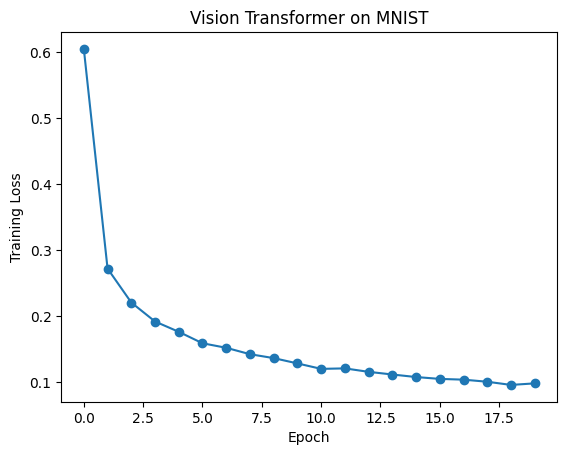

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# 1. Download and load the MNIST dataset
# -------------------------------
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# -------------------------------
# 2. Define the Vision Transformer model
# -------------------------------
class ViT(nn.Module):
    def __init__(self, image_size=28, patch_size=7, num_classes=10,
                 dim=64, depth=2, heads=4, mlp_dim=128, dropout=0.1):
        """
        image_size: size of the input image (28 for MNIST)
        patch_size: size of each patch (e.g., 7x7)
        num_classes: number of classification classes (10 for MNIST)
        dim: dimension of the patch embedding
        depth: number of Transformer encoder layers
        heads: number of heads in multi-head attention
        mlp_dim: hidden layer size in the feed-forward network
        dropout: dropout rate
        """
        super().__init__()
        
        # Divide the image into patches and perform a linear projection via a convolution
        self.patch_embed = nn.Conv2d(1, dim, kernel_size=patch_size, stride=patch_size)
        # Calculate the number of patches: (image_size/patch_size)^2
        self.num_patches = (image_size // patch_size) ** 2
        
        # Create a learnable class token
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        # Create learnable position embeddings (for both class token and patch tokens)
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + self.num_patches, dim))
        self.dropout = nn.Dropout(dropout)
        
        # Define the Transformer encoder using PyTorch's built-in TransformerEncoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads,
                                                   dim_feedforward=mlp_dim, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        
        # Apply layer normalization
        self.norm = nn.LayerNorm(dim)
        # Classification head that outputs logits for each class
        self.head = nn.Linear(dim, num_classes)
    
    def forward(self, x):
        # x shape: (batch, 1, 28, 28)
        x = self.patch_embed(x)             # (batch, dim, 4, 4) if patch_size=7
        x = x.flatten(2)                    # (batch, dim, num_patches)
        x = x.transpose(1, 2)               # (batch, num_patches, dim)
        
        batch_size = x.shape[0]
        # Expand the class token to match the batch size
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (batch, 1, dim)
        x = torch.cat((cls_tokens, x), dim=1)   # (batch, 1+num_patches, dim)
        x = x + self.pos_embed                # Add positional encoding
        x = self.dropout(x)
        
        # Transformer requires (sequence_length, batch, dim)
        x = x.transpose(0, 1)
        x = self.transformer(x)
        x = x.transpose(0, 1)
        
        # Extract the class token output
        x = self.norm(x[:, 0])
        out = self.head(x)
        return out

# -------------------------------
# 3. Training and Testing Functions
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def test(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# -------------------------------
# 4. Run Training and Testing
# -------------------------------
num_epochs = 20
train_losses = []

for epoch in range(num_epochs):
    loss = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(loss)
    test_acc = test(model, test_loader, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Test Acc: {test_acc*100:.2f}%")

# Plot and save the training loss curve
plt.plot(train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Vision Transformer on MNIST")
plt.savefig("vit_mnist_training_loss.png")  # Save as PNG in the current folder
plt.show()


## Quantum Vision Transformer (QViT) Architecture Overview and the Advantages of Quantum Patch Embedding

According to the paper [Quantum Vision Transformers (arXiv:2209.08167)](https://arxiv.org/pdf/2209.08167), the overall architecture of a Quantum Vision Transformer (QViT) can be roughly divided into three key stages:

1. **Quantum Patch Embedding**
2. **Quantum Transformer Encoder**
3. **Quantum Classifier**

Here, we first provide a detailed introduction to **Quantum Patch Embedding**.

### Quantum Patch Embedding

In traditional Vision Transformers (ViT), the input image is first split into many fixed-size patches. These patches are then flattened into vectors and passed through a linear embedding layer to obtain a vector representation. However, this method is fundamentally a linear operation and may not fully capture the complex nonlinear features present in image data.

In contrast, quantum computing possesses unique properties such as a **high-dimensional Hilbert space**, **quantum entanglement**, and **quantum interference**. These characteristics enable Quantum Patch Embedding to theoretically achieve a more powerful feature representation than traditional linear embedding.

Specifically, in QViT we can utilize Parameterized Quantum Circuits (PQCs) as a tool for patch embedding to encode the information of each image patch into a quantum state. This process can be implemented via **Quantum Feature Maps** in the following manner:

- Each image patch is converted into a one-dimensional vector, which serves as the input to the PQC.
- The PQC uses rotation gates (e.g., `RY`, `RX`, `RZ`) where each element of the vector determines the rotation angle or parameter, thereby embedding the classical vector into a quantum state.
- Due to the inherent nonlinear properties of quantum states in the Hilbert space and the entanglement structure within the quantum circuit, QViT is able to capture complex, nonlinear patterns in the data—surpassing the expressive capability of conventional linear embedding.

### Specific Advantages of Quantum Patch Embedding

1. **High-Dimensional Expressive Capacity:**  
   Quantum states reside in an exponentially large Hilbert space, enabling the model to represent complex features in images more effectively.

2. **Nonlinear Feature Extraction:**  
   Unlike linear layers, the inherent nonlinearity of quantum rotation gates and entangling operations allows for more efficient capture of nonlinear features.

3. **Quantum Entanglement and Interference Effects:**  
   Through quantum entanglement, information from different dimensions can interact more deeply, leading to richer and more effective feature fusion and representation.

4. **Potential Quantum Advantage:**  
   As quantum hardware continues to advance, the parallelism and other unique properties of quantum computation may accelerate the encoding and processing of image features.

By leveraging these approaches, Quantum Patch Embedding is expected to enhance the model's ability to understand and learn from image data. In turn, this improved representation will contribute to higher overall classification performance in subsequent stages of the Quantum Transformer Encoder and Quantum Classifier, thereby fully exploiting the potential of quantum computing in machine learning.


### Quantum Transformer Encoder

In the Quantum Transformer Encoder stage, the goal is to process the quantum-embedded patch representations and capture inter-patch relationships, analogous to the self-attention mechanism in classical Transformers. However, instead of using explicit attention weights computed via softmax functions and matrix multiplications, a Quantum Transformer Encoder leverages the unique properties of quantum circuits such as interference and entanglement.

**Key Concepts:**

1. **Parameterized Quantum Layers:**  
   Just like classical Transformer encoders consist of multiple layers of self-attention and feed-forward networks, the quantum version employs several layers of parameterized quantum circuits (PQCs). These layers can include:
   - **Single-qubit rotations:** Apply parameterized rotation gates (e.g., RY, RX) to individual qubits to adjust their quantum state.
   - **Entangling Gates:** Use entangling operations (such as CNOT or CZ gates) to allow information exchange between different patch embeddings. This enables the circuit to capture correlations between different patches.

2. **Quantum Self-Attention Analog:**  
   Although an exact quantum analog of the softmax-based self-attention is still an open research topic, one approach is to design PQCs where the interference patterns in the quantum state mimic the effect of computing similarity scores between patches. The inherent parallelism of quantum computation might allow for a more efficient encoding of such relational information.

3. **Equivariance & Parameter Sharing:**  
   By carefully designing the quantum circuit structure—possibly enforcing symmetry constraints—the quantum encoder can maintain equivariance with respect to certain transformations (e.g., permutation or mirror symmetry). This ensures that the encoded information is robust and preserves essential properties of the input image patches.

**Implementation Idea:**  
A possible implementation might involve stacking several blocks, where each block consists of:
- A layer of parameterized single-qubit rotations,
- Followed by a layer of entangling gates (e.g., a chain of CNOTs between neighboring qubits),
- And optionally another layer of rotations to further mix the information.

This block can be repeated multiple times to form the full Quantum Transformer Encoder.

---

### Quantum Classifier

After the Quantum Transformer Encoder processes the embedded patch information, the final stage is to classify the input image based on the transformed quantum state. The Quantum Classifier can be implemented in one of two ways:

1. **Hybrid Approach:**  
   The quantum circuit is measured to extract classical features (e.g., expectation values of certain observables), which are then fed into a classical classifier (such as a fully connected neural network). This approach leverages quantum processing for feature extraction while using classical layers for final classification.

2. **Fully Quantum Classifier:**  
   Alternatively, one may design a fully parameterized quantum circuit as the classifier. In this case, after the encoder, additional quantum layers are applied and then the final quantum state is measured directly. The measurement outcomes (or expectation values) are used to compute a loss function (e.g., cross-entropy) and optimize the parameters of the entire circuit in an end-to-end manner.

**Key Concepts:**

- **Measurement Strategy:**  
  Depending on the design, measurements can be performed on a specific qubit (e.g., a designated classification qubit) or on multiple qubits with subsequent classical post-processing to form the final prediction.

- **Loss Function & Training:**  
  The classifier is trained using standard loss functions (e.g., cross-entropy loss) comparing the measurement outcomes with the true labels. The gradients are computed using quantum automatic differentiation techniques, allowing the entire quantum circuit to be optimized.

**Implementation Idea:**  
For a hybrid approach, the Quantum Classifier may simply consist of a final layer that applies a few more PQC layers and then measures a set of observables. The measured expectation values are concatenated and fed into a classical fully-connected layer to output the final class probabilities. In a fully quantum approach, the classification result is directly inferred from the measurement statistics of a carefully chosen observable.

---

### Summary

To summarize, a Quantum Vision Transformer (QViT) can be conceptualized as follows:

1. **Quantum Patch Embedding:**  
   - The image is divided into patches.
   - Each patch is embedded into a quantum state using a Parameterized Quantum Circuit (PQC), analogous to Quantum Feature Maps.
   - This leverages quantum properties such as interference and entanglement to capture complex, non-linear relationships.

2. **Quantum Transformer Encoder:**  
   - Stacked PQC layers process the embedded patches, incorporating both local rotations and entangling operations.
   - This stage acts similarly to the self-attention mechanism by allowing patch-to-patch interactions and information mixing.
   - Equivariance and parameter sharing can be enforced to maintain symmetry properties.

3. **Quantum Classifier:**  
   - The final encoded quantum state is measured.
   - Either a hybrid model (quantum feature extraction followed by a classical classifier) or a fully quantum classifier is applied to generate the final prediction.

This architecture is promising because it exploits the high-dimensional Hilbert space and unique quantum effects to potentially capture more intricate data relationships than classical models, which may lead to enhanced performance in image classification tasks.
